In [3]:
from explore import Trainer, Unet, generate_image_with_sphere_numpy, DataLoader, SphereDataset

images = generate_image_with_sphere_numpy(n_images=1000)
ds = SphereDataset(images)
train_dataloader = DataLoader(ds, batch_size=1, shuffle=False)
kernel_sizes = [3,5,7,9]
last_reconstructions = []
for k in kernel_sizes:
    model = Unet(2, 2, 32, 2, kernel_size=k, avg_pool=True)
    trainer = Trainer(model, train_dataloader, train_dataloader, k)
    input_images, reconstructed_images = trainer.fit()
    last_reconstructions.append(reconstructed_images[-1])
    # name = str(k) +  "_" "reconstruction" + ".pdf"
    # plot_images(reconstructed_images, name)
# plot_images(input_images, "input.pdf")



KeyboardInterrupt: 

In [2]:
last_reconstructions

[tensor([[14.6322, 11.3229,  3.6087,  ...,  6.2292,  7.3023, 10.1541],
         [ 8.5101,  8.2415,  5.7007,  ...,  7.4505,  7.5303,  5.8621],
         [ 5.8470,  5.5990,  4.4483,  ...,  6.9416,  7.4461,  6.1814],
         ...,
         [ 3.3235,  4.1564,  2.1771,  ...,  3.5574,  5.6630,  5.9945],
         [ 4.9639,  5.5340,  2.8902,  ...,  6.6470,  4.7922,  5.8941],
         [10.2197,  8.6302,  4.6806,  ...,  7.0478,  7.3739,  9.5282]],
        grad_fn=<ToCopyBackward0>),
 tensor([[ 9.9314, 11.9175,  3.9401,  ...,  2.9460,  1.5855,  9.7346],
         [ 8.4106,  8.5350,  4.7970,  ...,  4.8405,  3.3389,  5.8377],
         [ 2.5159,  3.1575,  5.8637,  ...,  3.9571,  2.4536,  2.4035],
         ...,
         [ 1.1246,  4.9950,  5.1582,  ...,  2.1825,  3.6823,  2.7829],
         [ 1.6613,  4.2617,  5.7932,  ...,  2.9948,  2.0577,  6.3825],
         [11.0961,  8.6649,  5.9670,  ...,  0.7151,  6.7600,  9.8828]],
        grad_fn=<ToCopyBackward0>),
 tensor([[28.2402, 28.1137, 14.0885,  ..., 12.

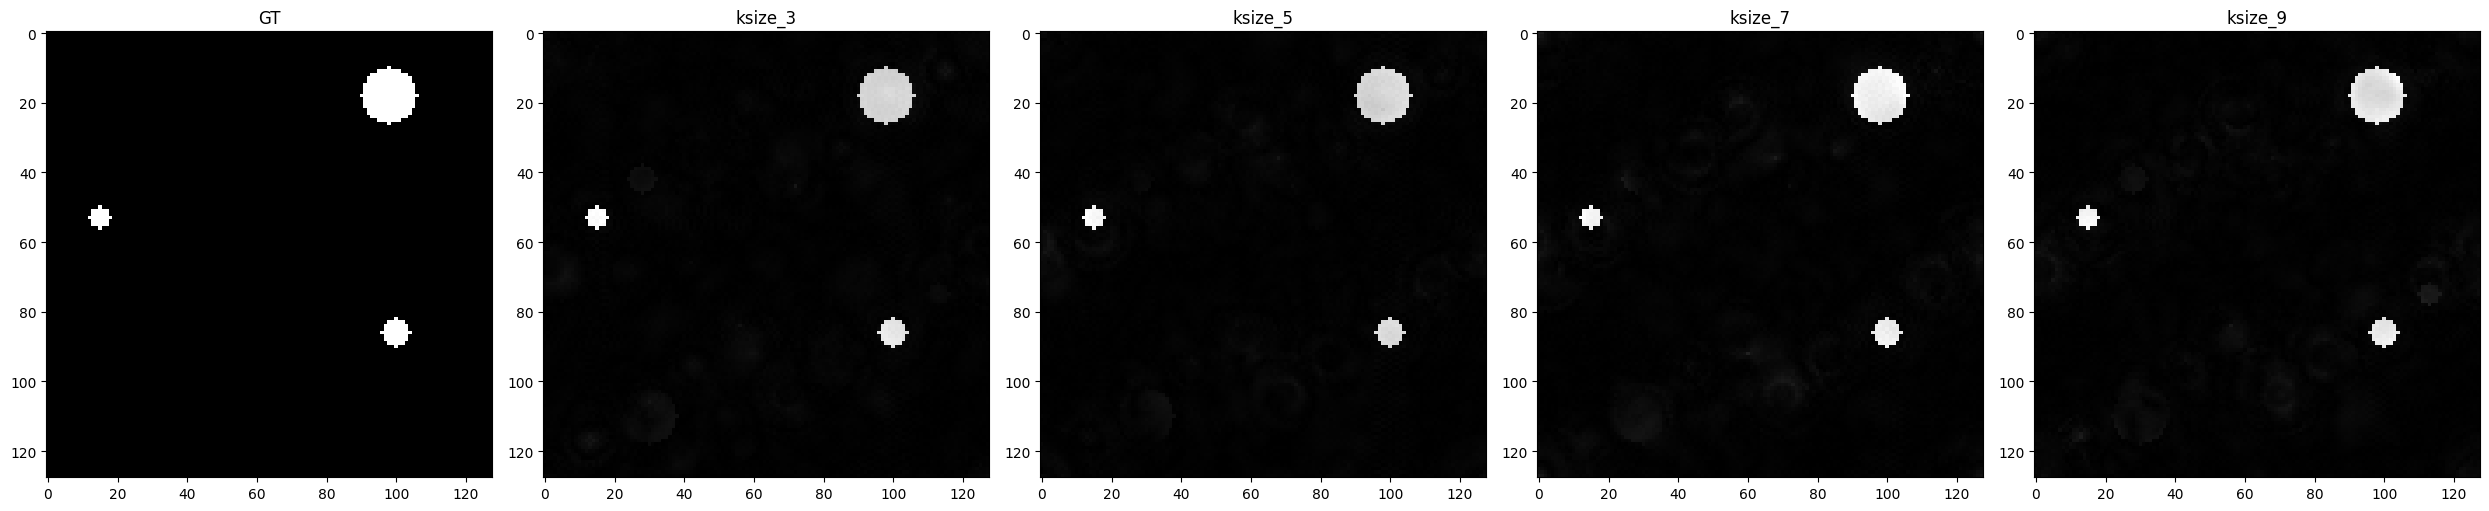

In [3]:
import matplotlib.pyplot as plt

last_reconstructions.insert(0, input_images[-1])
titles = ["GT", "ksize_3", "ksize_5", "ksize_7", "ksize_9"]
fig, axes = plt.subplots(1, 5, figsize=(25, 25))
for ax, img, title in zip(axes.flat, last_reconstructions, titles):
    ax.imshow(img.detach(), cmap='gray')
    ax.set_title(title)
plt.tight_layout()
plt.show()

In [ ]:
from modules.transforms import KspaceLDMDataTransform, KspaceUNetDataTransform
from fastmri.pl_modules import FastMriDataModule
from pathlib import Path
import torch
from torch import nn, optim
import fastmri
from fastmri.data.transforms import complex_center_crop, VarNetDataTransform
from modules.transforms import kspace_to_mri
import matplotlib.pyplot as plt
from typing import Tuple
from explore import Trainer, Unet, generate_image_with_sphere_numpy, DataLoader, SphereDataset
from fastmri.data.subsample import create_mask_for_mask_type
from modules.autoencoders import DeepAutoencoder

def norm(x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # group norm
        b, c, h, w = x.shape
        x = x.view(b, 2, c // 2 * h * w)
        mean = x.mean(dim=2).view(b, 2, 1, 1)
        std = x.std(dim=2).view(b, 2, 1, 1)

        x = x.view(b, c, h, w)

        return (x - mean) / std, mean, std

def unnorm(x: torch.Tensor, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        return x * std + mean

def min_max_normalize(x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    return (x-x.min())/(x.max() - x.min()), x.max(), x.min()

def min_max_unnormalize(x: torch.Tensor, maxi: torch.Tensor, mini: torch.Tensor) -> torch.Tensor:
    x_min = mini
    x_max = maxi
    return x*(x_max - x_min) + x_min

def m_norm(x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
     # group norm
    b, c, h, w = x.shape
    x = x.view(b, 2, c // 2 * h * w)

    maxi = x.max(dim=2)[0].view(b, 2, 1, 1)
    mini  = x.min(dim=2)[0].view(b, 2, 1, 1)

    x = x.view(b, c, h, w)

    return (x - mini) / (maxi - mini), maxi, mini

def m_unnorm(x: torch.Tensor, maxi: torch.Tensor, mini: torch.Tensor) -> torch.Tensor:
    return x*(maxi - mini) + mini

import torch
import torch.nn as nn

def laplace_init_all_weights(model, loc=0.0, scale=0.01):
    """
    Applies Laplace-distributed initialization to all weights and zeros to all biases in a model.
    
    Args:
        model: PyTorch nn.Module
        loc: Mean (location) of Laplace distribution
        scale: Scale (diversity) of Laplace distribution
    """
    for name, param in model.named_parameters():
        if 'weight' in name:
            with torch.no_grad():
                param.copy_(torch.distributions.Laplace(loc, scale).sample(param.shape))
        elif 'bias' in name:
            nn.init.constant_(param, 0)

mask_type = "random"
center_fractions = [0.04]
accelerations = [4]
mask = create_mask_for_mask_type(
    mask_type, center_fractions, accelerations
)

train_transform = val_transform = test_transform = KspaceUNetDataTransform(mask_func=mask)
# train_transform = val_transform = test_transform = UnetDataTransform(which_challenge="singlecoil")
# ptl data module - this handles data loaders
data_module = FastMriDataModule(
    data_path=Path("/vol/datasets/cil/2021_11_23_fastMRI_data/knee/unzipped"),
    challenge="singlecoil",
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=test_transform,
    combine_train_val=False,
    test_split="test",
    sample_rate=None,
    batch_size=1,
    num_workers=4,
    distributed_sampler=False,
    use_dataset_cache_file=True
)

train_dataloader = data_module.train_dataloader()
model = Unet(2,2, 16, 4, kernel_size=3, drop_prob=0.1)
# model = DeepAutoencoder(32, 128, num_input_channels=2)
class Trainer():
    def __init__(self, model, train_dl, test_dl):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # print(self.device)
        self.model = model.to(self.device)
        self.train_dataloader = train_dl
        self.test_dataloader = test_dl
        self.criterion = nn.L1Loss()
        self.optimizer = optim.Adam(model.parameters(), lr=1e-4)
        self.epochs = 2
    
    def fit(self):
        input_images = []
        reconstructed_images = []
        for epoch in range(self.epochs):
            for batch_idx, batch in enumerate(self.train_dataloader):
                mask = batch.mask
                mask = mask.to(self.device)
                input =  batch.masked_kspace
                reference = batch.full_kspace
                reference = reference.to(self.device)
                input = input.permute(0,3,1,2).contiguous()
                self.optimizer.zero_grad()
                input = input.to(self.device)
                # print(input.shape)
                input, mean, std = norm(input)
                output = self.model(input)
                input = unnorm(input, mean, std)
                output = unnorm(output, mean, std)
                input = input.permute(0,2,3,1).contiguous()
                output = output.permute(0,2,3,1).contiguous()
                zero = torch.zeros(1, 1, 1, 1).to(self.device)
                soft_dc = torch.where(mask, output - input, zero)
                output = output - soft_dc
                input_img = kspace_to_mri(input, (320,320))
                output_img = kspace_to_mri(output, (320, 320))
                reference_img = kspace_to_mri(reference, (320,320))
                loss = self.criterion(reference_img, output_img)
                loss.backward()
                self.optimizer.step()

                if batch_idx %  100 == 0:
                    print(f'Epoch {epoch+1}/{self.epochs}, Batch {batch_idx}, Loss: {loss.item()}')
                    plt.imshow(input_img.cpu().detach().squeeze(0),cmap="gray")
                    plt.title("Undersampled")
                    plt.show()
                    plt.imshow(output_img.cpu().detach().squeeze(0),cmap="gray")
                    plt.title("Undersampled Recon")
                    plt.show()
                    plt.imshow(reference_img.cpu().detach().squeeze(0),cmap="gray")
                    plt.title("Full")
                    plt.show()
                    # input_images.append(batch.squeeze().cpu())
                    # reconstructed_images.append(batch_reconstructed.cpu())
        return input_images, reconstructed_images
    
batch = next(iter(train_dataloader))
trainer = Trainer(model, train_dataloader, train_dataloader)
trainer.fit()

/vol/ideadata/ce84pegu/kspace-diffusion/kdiff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x235520 and 1024x128)

In [25]:
full_kspace = batch.full_kspace
masked_kspace = batch.masked_kspace
mask = batch.mask

In [26]:
full_kspace.shape

torch.Size([1, 640, 372, 2])

In [27]:
zero = torch.zeros(1, 1, 1, 1)
soft_dc = torch.where(mask, masked_kspace - masked_kspace, zero)
soft_dc.shape

torch.Size([1, 640, 372, 2])

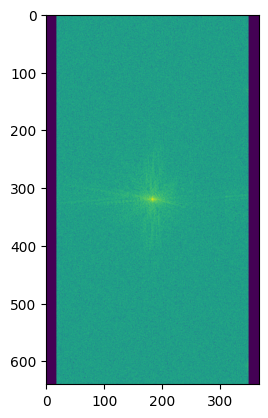

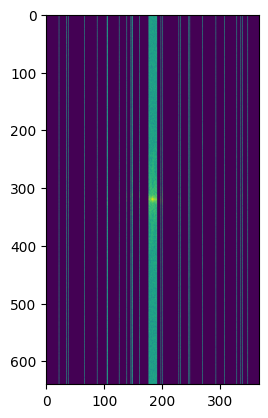

In [20]:
import matplotlib.pyplot as plt
import fastmri.data.transforms as fT
import numpy as np
def plot_kspace(x: torch.Tensor):
    x = fT.tensor_to_complex_np(x.squeeze(0))
    plt.imshow(np.log(np.abs(x) + 1e-9))
    plt.show()

plot_kspace(full_kspace)
plot_kspace(masked_kspace)

In [35]:
def z_score_normalize(tensor):
    """
    Applies per-channel z-score normalization to a tensor of shape (1, C, H, W).

    Returns:
        Tensor with zero mean and unit variance per channel.
    """
    assert tensor.ndim == 4 and tensor.shape[0] == 1, "Expected shape (1, C, H, W)"

    mean = tensor.mean(dim=(2, 3), keepdim=True)  # Per-channel mean
    std = tensor.std(dim=(2, 3), keepdim=True)    # Per-channel std
    # std = torch.where(std == 0, torch.ones_like(std), std)  # Avoid divide-by-zero

    normalized = (tensor - mean) / std
    return normalized

x = torch.randn(1, 2, 320, 320)
x_normalized = z_score_normalize(x)

# Check mean and std
print(x_normalized.mean(dim=(2,3)))  # Should be ~0
print(x_normalized.std(dim=(2,3)))   # Should be ~1


tensor([[ 9.0152e-09, -1.0878e-08]])
tensor([[1., 1.]])


In [80]:
kspace_sample = next(iter(train_dataloader)).kspace
kspace_sample = complex_center_crop(kspace_sample, (320,320))
kspace_sample = kspace_sample.permute(0,3,1,2).contiguous()
laplace_sample = torch.distributions.Laplace(kspace_sample.mean(), torch.mean(torch.abs(kspace_sample - kspace_sample.mean()))).sample((1,2,320,320))
kspace_norm, mean, std = norm(kspace_sample)
m_kspace, _, _ = min_max_normalize(kspace_sample)
kspace_norm_r, kspace_norm_im = kspace_norm[:,0:1,...], kspace_norm[:,1:2,...]
kspace_norm_r = kspace_norm_r.flatten().numpy()
kspace_norm_im = kspace_norm_im.flatten().numpy()
kspace_sample_r, kspace_sample_im = kspace_sample[:,0:1,...], kspace_sample[:,1:2,...]
kspace_sample = kspace_sample.flatten().numpy()
kspace_sample_r = kspace_sample_r.flatten().numpy()
kspace_sample_im = kspace_sample_im.flatten().numpy()
kspace_norm = kspace_norm.flatten().numpy()
m_kspace = m_kspace.flatten().numpy()

torch.Size([1, 2])


In [81]:
laplace_sample = laplace_sample.flatten().numpy()

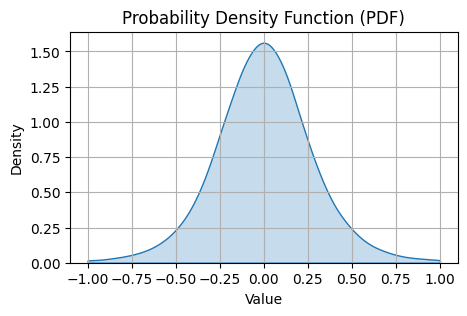

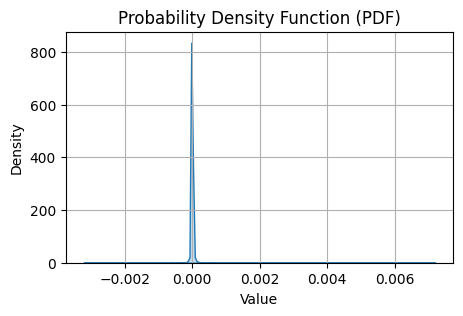

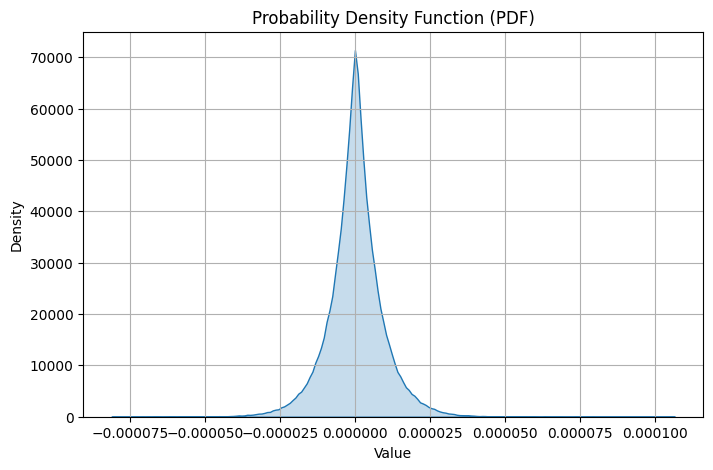

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 3))
sns.kdeplot(kspace_norm, bw_adjust=0.5, fill=True, clip=(-1, 1))
# sns.kdeplot(kspace_norm_im, bw_adjust=0.5, fill=True, color="r")
plt.title("Probability Density Function (PDF)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 3))
sns.kdeplot(kspace_sample, bw_adjust=0.5, fill=True, clip=(-1, 1))
plt.title("Probability Density Function (PDF)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
sns.kdeplot(laplace_sample, bw_adjust=0.5, fill=True, clip=(-1,1))
plt.title("Probability Density Function (PDF)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.show()

In [ ]:
import h5py
from fastmri.data import SliceDataset
path = "/vol/datasets/cil/2021_11_23_fastMRI_data/knee/unzipped/singlecoil_train/file1002276.h5"

file =h5py.File(path)
print("Keys: ", list(file.keys()))
print("Attributes: ", dict(file.attrs))
dict(file["reconstruction_rss"].attrs)

Keys:  ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attributes:  {'acquisition': 'CORPD_FBK', 'max': np.float64(0.0009115110079568145), 'norm': np.float64(0.25269182883545577), 'patient_id': '047ba528f6e4071959f7a1b2f9c3c39951db6423ef914d2f5c51f63a03ee16dc'}


{}

In [24]:
import numpy as np
data = np.random.randn(20,20,3)
with h5py.File("example_1.h5", "w") as h5_file:
    h5_file.create_dataset("random_data", data=data)
    h5_file.attrs["slice_number"] = 20
    h5_file.close()


In [27]:
hf = h5py.File("example_1.h5")
print(hf.keys())
print(dict(hf.attrs))
hf.close()

<KeysViewHDF5 ['random_data']>
{'slice_number': np.int64(20)}
